In [13]:
# Ensure the project root is in PATH.
import sys

sys.path.append("../")
# All imports of our code are relative to the project root.

from backtester.backtester import Backtester
from backtester.datamodel import TradingState, OrderDepth, Order, Listing
import matplotlib.pyplot as plt

from backtester.log import Log
import numpy as np
import pandas as pd
import sys
import os
from collections import defaultdict


# concatenates multiple days of historical data into 1.
# drops day column and replaces it with continuous timestamps.
# i.e. day -1 timestamp 0 becomes just timestamp 1,000,000
def concatenate_historical_data(data: list[pd.DataFrame]) -> pd.DataFrame:
    output = data[0]

    for i in range(1, len(data), 1):
        timeshift = output.iloc[-1]["timestamp"] + 100  # 100 for next day
        next_day_copy = data[i].copy()
        next_day_copy["timestamp"] += timeshift

        output = pd.concat([output, next_day_copy])

    return output

In [14]:
market_data_round_3_day_0 = pd.read_csv(os.path.join("..", "data", "round3", "prices_round_3_day_0.csv"), sep=";")
market_data_round_3_day_1 = pd.read_csv(os.path.join("..", "data", "round3", "prices_round_3_day_1.csv"), sep=";")
market_data_round_3_day_2 = pd.read_csv(os.path.join("..", "data", "round3", "prices_round_3_day_2.csv"), sep=";")

trades_round_3_day_0 = pd.read_csv(os.path.join("..", "data", "round3", "trades_round_3_day_0.csv"), sep=";")
trades_round_3_day_1 = pd.read_csv(os.path.join("..", "data", "round3", "trades_round_3_day_1.csv"), sep=";")
trades_round_3_day_2 = pd.read_csv(os.path.join("..", "data", "round3", "trades_round_3_day_2.csv"), sep=";")


market_data_round_3_all3days = concatenate_historical_data([market_data_round_3_day_0, market_data_round_3_day_1, market_data_round_3_day_2])
trades_round_3_all3days = concatenate_historical_data([trades_round_3_day_0, trades_round_3_day_1, market_data_round_3_day_2])

# Combinations

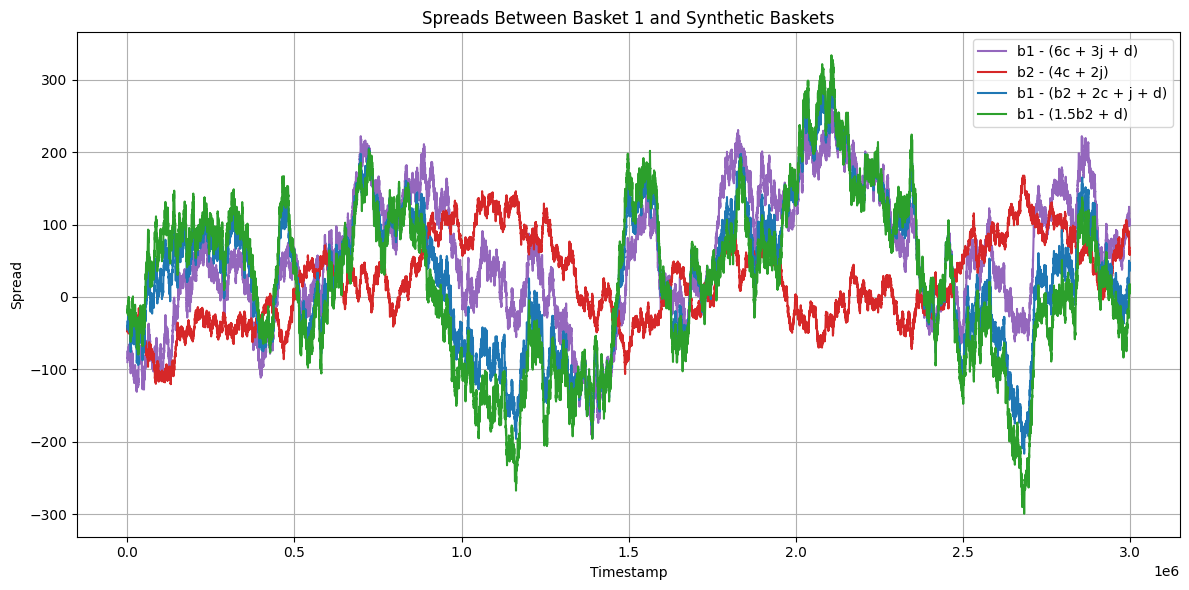

In [128]:
market_data = market_data_round_3_all3days.copy()
trade_history = trades_round_3_all3days.copy()


croissants = market_data[market_data["product"] == "CROISSANTS"].reset_index(drop=True)
jams = market_data[market_data["product"] == "JAMS"].reset_index(drop=True)
djembes = market_data[market_data["product"] == "DJEMBES"].reset_index(drop=True)
basket1 = market_data[market_data["product"] == "PICNIC_BASKET1"].reset_index(drop=True)
basket2 = market_data[market_data["product"] == "PICNIC_BASKET2"].reset_index(drop=True)


# ETF = NAV
synthetic_basket1_price = 6 * croissants["mid_price"] + 3 * jams["mid_price"] + 1 * djembes["mid_price"]

# ETF = NAV
synthetic_basket2_price = 4 * croissants["mid_price"] + 2 * jams["mid_price"]

# ETF1 = ETF2 + AUG
augumented_basket1_price = basket2['mid_price'] + 2 * croissants["mid_price"] + 1 * jams["mid_price"] + 1 * djembes["mid_price"]

# ETF1 = 1.5*ETF2 + DJEMBE
artifical_basket1_price = basket2['mid_price']*1.5 + 1*djembes['mid_price']

# Spreads
spread_b1 = basket1['mid_price'] - synthetic_basket1_price
spread_b2 = basket2['mid_price'] - synthetic_basket2_price
spread_b1b2_p = basket1["mid_price"] - augumented_basket1_price
spread_b1b2_m = basket1['mid_price'] - artifical_basket1_price

# Plot
plt.figure(figsize=(12, 6))
plt.plot(basket1["timestamp"], spread_b1, color="tab:purple", label="b1 - (6c + 3j + d)")
plt.plot(basket1["timestamp"], spread_b2, color="tab:red", label="b2 - (4c + 2j)")
plt.plot(basket1["timestamp"], spread_b1b2_p, color="tab:blue", label="b1 - (b2 + 2c + j + d)")
plt.plot(basket1["timestamp"], spread_b1b2_m, color="tab:green", label="b1 - (1.5b2 + d)")

plt.title("Spreads Between Basket 1 and Synthetic Baskets")
plt.xlabel("Timestamp")
plt.ylabel("Spread")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()


Previously it was found that we should simply just long/short pairs trade when there is a spread, with position sizing proportional to the size of the spread.  

However that was only with basket2, now we want to apply this to all baskets. There should be a linear relationship between the spreads? Just want to confirm this. Equations suggest but want to make sure

In [16]:
import statsmodels.api as sm


X = pd.DataFrame(columns=['spread_b1', 'spread_b2'])
X['spread_b1']= spread_b1
X['spread_b2'] = spread_b2
X = sm.add_constant(X)
y = spread_b1b2_p


model = sm.OLS(y, X).fit()

print(model.summary())

                            OLS Regression Results                            
Dep. Variable:              mid_price   R-squared:                       1.000
Model:                            OLS   Adj. R-squared:                  1.000
Method:                 Least Squares   F-statistic:                 7.892e+33
Date:                Tue, 15 Apr 2025   Prob (F-statistic):               0.00
Time:                        12:56:36   Log-Likelihood:             2.9202e+05
No. Observations:               10000   AIC:                        -5.840e+05
Df Residuals:                    9997   BIC:                        -5.840e+05
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const      -1.651e-14   6.31e-16    -26.177      0.0

Lets analyse the possible combinations:  

Firstly, if we zoom in on (constituents, basket2), its quite obvious that we just long/short whenever one is above the other.  

However our position limits mean we cannot go too much long or short on something while staying properly hedged. For example wanting to full short Basket1 means we have to buy 60*6 croissants to hedge but we have a position limit of 250. However what we can do is we can short basket2 for example?  

There is no point taking on extra position that isn't hedged because then we are just betting directionally on something we have no signal/edge on while taking on that variance - thus no point.  

Just figure out at each point what combos we should be taking?  

To determine this, we should calculate what we would make if we were an AP, because that is our EV here - the spread is mean reverting. Just take the sequence of trades with the highest EV  


Assume for now we can take full position at each timestamp no matter what the edge is (as long as the edge is finite).  

Later when we adjust this to a sizing scheme we just multiply everything by a constant.  

Suppose we have a scenario like both ETFS are priced higher than their NAV. Then what we should do is take the one that allows us to gain the most profit per position?  



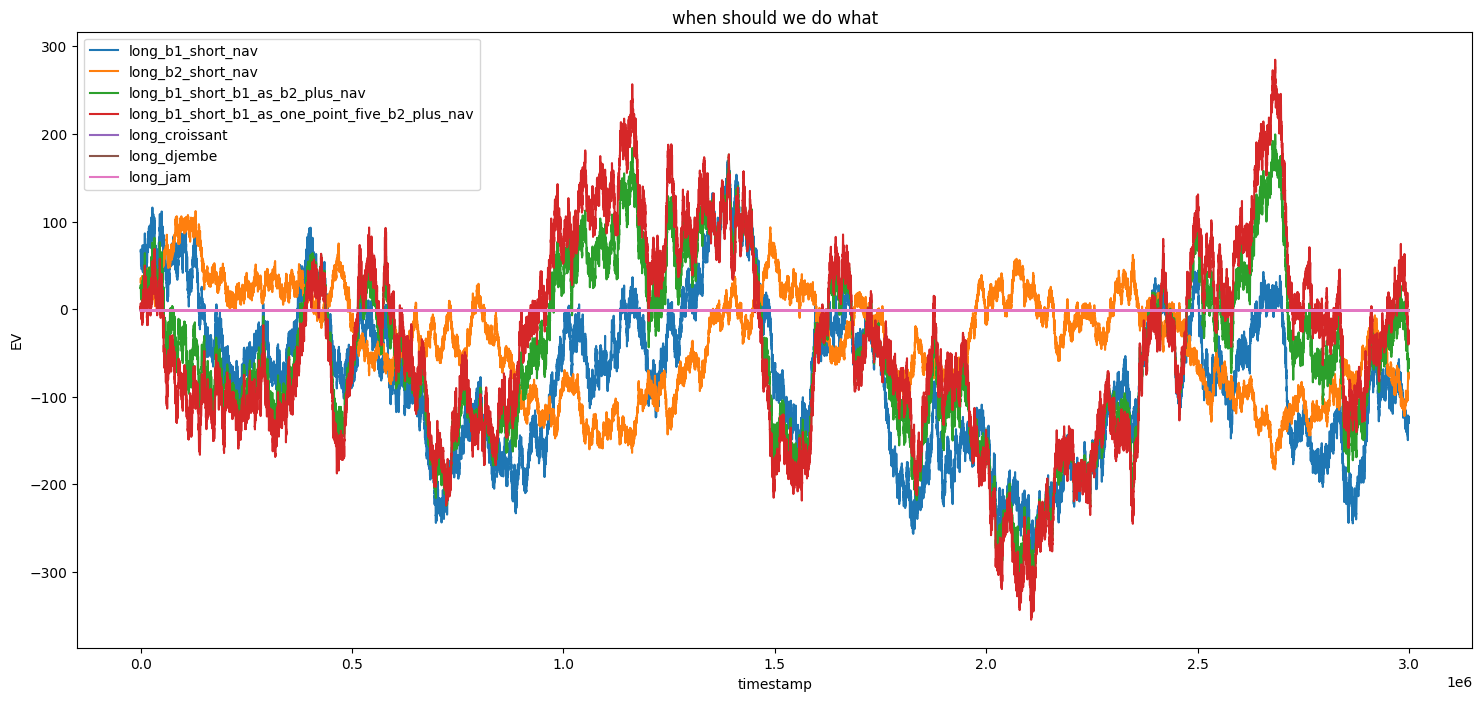

1.2057666666666667
1.2644666666666666
1.6177666666666666
9.192866666666667
5.1976


In [170]:
CROISSANTS = "CROISSANTS"
DJEMBES = "DJEMBES"
JAMS = "JAMS"
KELP = "KELP"
PICNIC_BASKET1 = "PICNIC_BASKET1"
PICNIC_BASKET2 = "PICNIC_BASKET2"
RAINFOREST_RESIN = "RAINFOREST_RESIN"
SQUID_INK = "SQUID_INK"
VOLCANIC_ROCK = "VOLCANIC_ROCK"
VOLCANIC_ROCK_VOUCHER_10000 = "VOLCANIC_ROCK_VOUCHER_10000"
VOLCANIC_ROCK_VOUCHER_10250 = "VOLCANIC_ROCK_VOUCHER_10250"
VOLCANIC_ROCK_VOUCHER_10500 = "VOLCANIC_ROCK_VOUCHER_10500"
VOLCANIC_ROCK_VOUCHER_9500 = "VOLCANIC_ROCK_VOUCHER_9500"
VOLCANIC_ROCK_VOUCHER_9750 = "VOLCANIC_ROCK_VOUCHER_9750"
n = len(np.unique(market_data["timestamp"]))


def ap_profit() -> float:
    return 0


def long_b1_short_nav(orderqty: dict[str, int]):
    orderqty[PICNIC_BASKET1] += 1
    orderqty[CROISSANTS] += -6
    orderqty[JAMS] += -3
    orderqty[DJEMBES] += -1


def short_b1_long_nav(orderqty: dict[str, int]):
    orderqty[PICNIC_BASKET1] += -1
    orderqty[CROISSANTS] += 6
    orderqty[JAMS] += 3
    orderqty[DJEMBES] += 1


def long_b2_short_nav(orderqty: dict[str, int]):
    orderqty[PICNIC_BASKET2] += 1
    orderqty[CROISSANTS] += -4
    orderqty[JAMS] += -2


def short_b2_long_nav(orderqty: dict[str, int]):
    orderqty[PICNIC_BASKET2] += -1
    orderqty[CROISSANTS] += 4
    orderqty[JAMS] += 2


# every sequence of hedging trades is cycle detection??
# want to find the cycle with the maximum profit? i think this is NP hard.
# thats fine though.

# def short_b1_long_

profitability = {
    "timestamp": [],
    "long_b1_short_nav": [],
    "short_b1_long_nav": [],
    "long_b2_short_nav": [],
    "short_b2_long_nav": [],
    "long_b1_short_b1_as_b2_plus_nav": [],
    "short_b1_long_b1_as_b2_plus_nav": [],
    "long_b1_short_b1_as_one_point_five_b2_plus_nav": [],
    "short_b1_long_b1_as_one_point_five_b2_plus_nav": [],
    "long_croissant": [],
    "short_croissant": [],
    "long_djembe": [],
    "short_djembe": [],
    "long_jam": [],
    "short_jam": [],
}


croissants_prices = croissants["mid_price"]
jams_prices = jams["mid_price"]
djembes_prices = djembes["mid_price"]
basket1_prices = basket1["mid_price"]
basket2_prices = basket2["mid_price"]

croissants_spread = np.abs(croissants["bid_price_1"] - croissants["ask_price_1"])
djembes_spread = np.abs(djembes["bid_price_1"] - djembes["ask_price_1"])
jams_spread = np.abs(jams["bid_price_1"] - jams["ask_price_1"])


profitability_df = pd.DataFrame()

profitability_df['timestamp'] = np.unique(market_data['timestamp'])
profitability_df["c"] = croissants["mid_price"]
profitability_df["j"] = jams["mid_price"]
profitability_df["d"] = djembes["mid_price"]
profitability_df["b1"] = basket1["mid_price"]
profitability_df["b2"] = basket2["mid_price"]

profitability_df["spr_c"] = abs(croissants["bid_price_1"]- croissants["ask_price_1"])
profitability_df["spr_j"] = abs(jams["bid_price_1"]- jams["ask_price_1"])
profitability_df["spr_d"] = abs(djembes["bid_price_1"]- djembes["ask_price_1"])
profitability_df["spr_b1"] = abs(basket1["bid_price_1"]- basket1["ask_price_1"])
profitability_df["spr_b2"] = abs(basket2["bid_price_1"]- basket2["ask_price_1"])


profitability_df['sb1'] = profitability_df['b1'] - 6 * profitability_df['c'] - 3 * profitability_df['j'] - 1 * profitability_df['d']
profitability_df['sb2'] = profitability_df['b2'] - 4 * profitability_df['c'] - 2 * profitability_df['j']
 
profitability_df['b1_as_b2_plus_nav'] = profitability_df['b2'] + 2 * profitability_df['c'] + profitability_df['j'] + profitability_df['d']
profitability_df['b1_as_one_point_five_b2_plus_nav'] = 1.5 * profitability_df['b2'] + profitability_df['d']

profitability_df["long_b1_short_nav"] = -profitability_df['sb1'] - profitability_df['spr_b1'] - 6 * profitability_df['spr_c'] - 3 * profitability_df['spr_j'] - profitability_df['spr_d']
profitability_df["short_b1_long_nav"] =  profitability_df['sb1'] - profitability_df['spr_b1'] - 6 * profitability_df['spr_c'] - 3 * profitability_df['spr_j'] - profitability_df['spr_d']
profitability_df["long_b2_short_nav"] = -profitability_df['sb2'] - profitability_df['spr_b2'] - 4 * profitability_df['spr_c'] - 2 * profitability_df['spr_j']
profitability_df["short_b2_long_nav"] =  profitability_df['sb2'] - profitability_df['spr_b2'] - 4 * profitability_df['spr_c'] - 2 * profitability_df['spr_j']

profitability_df["long_b1_short_b1_as_b2_plus_nav"] = -(profitability_df['b1'] - profitability_df['b1_as_b2_plus_nav']) - profitability_df['spr_b1'] - profitability_df['spr_b2'] - 2 * profitability_df['spr_c'] - profitability_df['spr_j']
profitability_df["short_b1_long_b1_as_b2_plus_nav"] =  (profitability_df['b1'] - profitability_df['b1_as_b2_plus_nav']) - profitability_df['spr_b1'] - profitability_df['spr_b2'] - 2 * profitability_df['spr_c'] - profitability_df['spr_j']

profitability_df["long_b1_short_b1_as_one_point_five_b2_plus_nav"] = -(profitability_df['b1'] - profitability_df['b1_as_one_point_five_b2_plus_nav']) - profitability_df['spr_b1'] - 1.5 * profitability_df['spr_b2'] - profitability_df['spr_d']
profitability_df["short_b1_long_b1_as_one_point_five_b2_plus_nav"] =  (profitability_df['b1'] - profitability_df['b1_as_one_point_five_b2_plus_nav']) - profitability_df['spr_b1'] - 1.5 * profitability_df['spr_b2'] - profitability_df['spr_d']

profitability_df["long_croissant"] = -profitability_df['spr_c']
profitability_df["short_croissant"] = -profitability_df['spr_c']
profitability_df["long_djembe"] = -profitability_df['spr_d']
profitability_df["short_djembe"] = -profitability_df['spr_d']
profitability_df["long_jam"] = -profitability_df['spr_j']
profitability_df["short_jam"] = -profitability_df['spr_j']
 
# for i in range(n):
#     orderqty = defaultdict(int)
#     sb1 = spread_b1[i]
#     sb2 = spread_b2[i]

#     c = croissants_prices[i]
#     j = jams_prices[i]
#     d = djembes_prices[i]
#     b1 = basket1_prices[i]
#     b2 = basket2_prices[i]

#     # if sb1 > 0:
#     #     short_b1_long_nav(orderqty)
#     # elif sb1 < 0:
#     #     long_b1_short_nav(orderqty)
#     # if sb2 > 0:
#     #     short_b2_long_nav(orderqty)
#     # elif sb2 < 0:
#     #     long_b2_short_nav(orderqty)

#     profitability["timestamp"].append(i * 100)
#     profitability["long_b1_short_nav"].append(-sb1)
#     profitability["short_b1_long_nav"].append(sb1)
#     profitability["long_b2_short_nav"].append(-sb2)
#     profitability["short_b2_long_nav"].append(sb2)

#     b1_as_b2_plus_nav = b2 + 2 * c + j + d
#     b1_as_one_point_five_b2_plus_nav = 1.5 * b2 + d

#     profitability["long_b1_short_b1_as_b2_plus_nav"].append(-(b1 - b1_as_b2_plus_nav))
#     profitability["short_b1_long_b1_as_b2_plus_nav"].append(b1 - b1_as_b2_plus_nav)

#     profitability["long_b1_short_b1_as_one_point_five_b2_plus_nav"].append(-(b1 - b1_as_one_point_five_b2_plus_nav))
#     profitability["short_b1_long_b1_as_one_point_five_b2_plus_nav"].append(b1 - b1_as_one_point_five_b2_plus_nav)

#     profitability["long_croissant"].append(-croissants_spread[i])
#     profitability["short_croissant"].append(-croissants_spread[i])
#     profitability["long_djembe"].append(-djembes_spread[i])
#     profitability["short_djembe"].append(-djembes_spread[i])
#     profitability["long_jam"].append(-jams_spread[i])
#     profitability["short_jam"].append(-jams_spread[i])

# profitability_df = pd.DataFrame(profitability)

profitability = profitability_dict = profitability_df.to_dict(orient="list")

profitability_df


plt.figure(figsize=(18, 8))
for key in profitability.keys():
    if key == "timestamp" or key.find("long") != 0:
        continue
    plt.plot(profitability["timestamp"], profitability[key], label=key)
plt.title("when should we do what")
plt.xlabel("timestamp")
plt.ylabel("EV")
plt.legend()
plt.show()


print(np.mean(profitability_df["spr_c"]))
print(np.mean(profitability_df["spr_d"]))
print(np.mean(profitability_df["spr_j"]))
print(np.mean(profitability_df["spr_b1"]))
print(np.mean(profitability_df["spr_b2"]))

Lets experiment with my hypothesised $\mathbb{R}^{10}$ graph algorithm

In [ ]:
from collections import deque
import heapq
from tqdm import tqdm

node = tuple[int, int, int, int, int, int, int, int, int, int]
delta = tuple[int, int, int]
# {c,d,j}

POSLIMIT = (-250, -60, -350, -60, -100, 250, 60, 350, 60, 100)
# {minc, mind, minj, minb1, minb2, maxc, maxd, maxj, maxb1, maxb2}


edges = {
    "long_b1_short_nav": (-6, -1, -3, 0, 0, 0, 0, 0, 1, 0),
    "short_b1_long_nav": (0, 0, 0, -1, 0, 6, 1, 3, 0, 0),
    "long_b2_short_nav": (-4, 0, -2, 0, 0, 0, 0, 0, 0, 1),
    "short_b2_long_nav": (0, 0, 0, 0, -1, 4, 0, 2, 0, 0),
    "long_b1_short_b1_as_b2_plus_nav": (-2, -1, -1, 0, -1, 0, 0, 0, 1, 0),
    "short_b1_long_b1_as_b2_plus_nav": (0, 0, 0, -1, 0, 2, 1, 1, 0, 1),
    "long_b1_short_b1_as_one_point_five_b2_plus_nav": (0, -1, 0, 0, -1.5, 0, 0, 0, 1, 0),
    "short_b1_long_b1_as_one_point_five_b2_plus_nav": (0, 0, 0, -1, 0, 0, 1, 0, 0, 1.5),
    "long_croissant": (0, 0, 0, 0, 0, 1, 0, 0, 0, 0),
    "short_croissant": (0, 0, 0, 0, 0, -1, 0, 0, 0, 0),
    "long_djembe": (0, 0, 0, 0, 0, 0, 1, 0, 0, 0),
    "short_djembe": (0, 0, 0, 0, 0, 0, -1, 0, 0, 0),
    "long_jam": (0, 0, 0, 0, 0, 0, 0, 1, 0, 0),
    "short_jam": (0, 0, 0, 0, 0, 0, 0, -1, 0, 0),
}

edges_reverselookup = {v: k for k, v in edges.items()}


delta_changes = {
    "long_b1_short_nav": (0, 0, 0),
    "short_b1_long_nav": (0, 0, 0),
    "long_b2_short_nav": (0, 0, 0),
    "short_b2_long_nav": (0, 0, 0),
    "long_b1_short_b1_as_b2_plus_nav": (0, 0, 0),
    "short_b1_long_b1_as_b2_plus_nav": (0, 0, 0),
    "long_b1_short_b1_as_one_point_five_b2_plus_nav": (0, 0, 0),
    "short_b1_long_b1_as_one_point_five_b2_plus_nav": (0, 0, 0),
    "long_croissant": (1, 0, 0),
    "short_croissant": (-1, 0, 0),
    "long_djembe": (0, 1, 0),
    "short_djembe": (0, -1, 0),
    "long_jam": (0, 0, 1),
    "short_jam": (0, 0, -1),
}

# # imbalance (for calculating hedging).
# # Returns net [c,d,j] equivalent
# def net_imbalance(orderqty: dict[str, int]) -> tuple[int, int, int]:
#     c = orderqty[CROISSANTS] + 6 * orderqty[PICNIC_BASKET1] + 4 * orderqty[PICNIC_BASKET2]
#     d = orderqty[DJEMBES] + orderqty[PICNIC_BASKET1]
#     j = orderqty[JAMS] + 3 * orderqty[PICNIC_BASKET1] + 2 * orderqty[PICNIC_BASKET2]

#     return (c, d, j)


# def calculate_hedge_net(u: node):
#     return net_imbalance({CROISSANTS: u[0] + u[5], DJEMBES: u[1] + u[6], JAMS: u[2] + u[7], PICNIC_BASKET1: u[3] + u[8], PICNIC_BASKET2: u[4] + u[9]})


# does v respect position limits
def respect_position_limits(v: node, poslimit: node) -> bool:
    for i in range(5):
        if v[i] < poslimit[i]:
            return False

    for i in range(5, 10, 1):
        if v[i] > poslimit[i]:
            return False

    return True


# u + v
def addvert(u: node, v: node) -> node:
    return tuple(u[i] + v[i] for i in range(len(u)))


# u - v
def subvert(u: node, v: node) -> node:
    return tuple(u[i] - v[i] for i in range(len(u)))


def delta_penalty(d: delta) -> float:
    return abs(d[0]) + abs(d[1]) + abs(d[2])


def bfs(time_index: int, current_position: dict[str, int] = {}, max_depth: int = 500, unhedge_penalty=1):
    origin = (
        current_position.get(CROISSANTS, 0),
        current_position.get(DJEMBES, 0),
        current_position.get(JAMS, 0),
        current_position.get(PICNIC_BASKET1, 0),
        current_position.get(PICNIC_BASKET2, 0),
        current_position.get(CROISSANTS, 0),
        current_position.get(DJEMBES, 0),
        current_position.get(JAMS, 0),
        current_position.get(PICNIC_BASKET1, 0),
        current_position.get(PICNIC_BASKET2, 0),
    )

    origin_delta = (
        current_position.get(CROISSANTS, 0) + 6 * current_position.get(PICNIC_BASKET1, 0) + 4 * current_position.get(PICNIC_BASKET2, 0),
        current_position.get(DJEMBES, 0) + current_position.get(PICNIC_BASKET1, 0),
        current_position.get(JAMS, 0) + 3 * current_position.get(PICNIC_BASKET1, 0) + 2 * current_position.get(PICNIC_BASKET2, 0),
    )

    deltas = defaultdict(delta)
    profits = defaultdict(float)
    visited = set()
    backedges = defaultdict(node)  # if u + du = v, backedge[v] = du
    q = []

    visited.add(origin)
    deltas[origin] = origin_delta
    profits[origin] = 0 - unhedge_penalty * delta_penalty(origin_delta)
    heapq.heappush(q, (-profits[origin], origin))  # Store (-profit, node) (heapq is minheap but we want maxheap)

    while len(q) != 0 and len(visited) < max_depth:

        _, u = heapq.heappop(q)
        for edgelabel, edge in edges.items():
            v = addvert(u, edge)

            delta_u = deltas[u]
            delta_v = addvert(deltas[u], delta_changes[edgelabel])
            delta_penalty_u = delta_penalty(delta_u)
            delta_penalty_v = delta_penalty(delta_v)

            newprofit = profits[u] + profitability[edgelabel][time_index] - unhedge_penalty * (delta_penalty_v - delta_penalty_u)

            if newprofit > profits[u] and v not in visited and respect_position_limits(v, POSLIMIT):
                profits[v] = newprofit
                deltas[v] =  delta_v
                visited.add(v)
                backedges[v] = edge
                heapq.heappush(q, (-profits[v], v))

    best_node = max(profits.items(), key=lambda item: item[1])
    # print(f"Best node: {best_node[0]}")
    # print(f"Max profit: {best_node[1]}")
    # print(f"Visited: {len(visited)} nodes")

    x = best_node[0]
    swaps = defaultdict(int)
    while x != origin:
        back = backedges[x]
        trade = edges_reverselookup[back]
        swaps[trade] += 1
        x = subvert(x, back)

    return swaps, best_node[1]


for i in range(10000): 
    print(bfs(time_index=i, current_position={CROISSANTS: -118, DJEMBES: 48, JAMS: -136 }, max_depth=20000, unhedge_penalty=5))

# issue is that when we are significantly unhedged we need more depth of search to find optimal solution
# we can combat this by adding edges that have multiple units for example instead of just hedging 1 croissant we can hedge 10.

(defaultdict(<class 'int'>, {'long_b1_short_b1_as_one_point_five_b2_plus_nav': 38, 'long_jam': 136, 'long_croissant': 118, 'short_djembe': 48, 'long_b1_short_nav': 22}), 1071.0)
(defaultdict(<class 'int'>, {'short_djembe': 48, 'long_croissant': 118, 'long_jam': 136, 'long_b1_short_nav': 22}), 1135.0)
(defaultdict(<class 'int'>, {'long_jam': 136, 'long_croissant': 118, 'short_djembe': 48, 'long_b1_short_b1_as_one_point_five_b2_plus_nav': 38, 'long_b1_short_nav': 22}), 1270.5)
(defaultdict(<class 'int'>, {'long_jam': 136, 'long_croissant': 118, 'short_djembe': 48, 'long_b1_short_nav': 22}), 1058.0)
(defaultdict(<class 'int'>, {'long_jam': 136, 'long_b1_short_b1_as_one_point_five_b2_plus_nav': 38, 'long_croissant': 118, 'short_djembe': 48, 'long_b1_short_nav': 22}), 1156.5)
(defaultdict(<class 'int'>, {'long_b1_short_b1_as_one_point_five_b2_plus_nav': 38, 'long_jam': 136, 'long_croissant': 118, 'short_djembe': 48, 'long_b1_short_nav': 22}), 943.5)
(defaultdict(<class 'int'>, {'long_croiss

KeyboardInterrupt: 

Figure out how much to dfs. Total tree size is about 180k but thats a lot.  
Time scales linearly with the number of nodes searched. 

In [165]:
bfsprofits = defaultdict(int)
for max_depth in tqdm(list(np.linspace(100, 1400, 20))):
    for timestamp in np.linspace(0, 9999, 400):
        _, profit = bfs(time_index=int(timestamp), current_position={CROISSANTS:200}, max_depth=int(max_depth), unhedge_penalty=200)
        bfsprofits[max_depth] += profit
bfsprofits

100%|██████████| 20/20 [00:40<00:00,  2.00s/it]


defaultdict(int,
            {100.0: -14396592.0,
             168.42105263157896: -13269604.5,
             236.8421052631579: -12219941.0,
             305.2631578947368: -11092953.5,
             373.6842105263158: -9967754.0,
             442.10526315789474: -8840369.5,
             510.52631578947364: -7790706.0,
             578.9473684210526: -6663718.5,
             647.3684210526316: -5536731.0,
             715.7894736842105: -4487067.5,
             784.2105263157895: -3360080.0,
             852.6315789473684: -2237099.25,
             921.0526315789473: -1229150.25,
             989.4736842105262: -143842.25,
             1057.8947368421052: 558503.25,
             1126.3157894736842: 1262559.75,
             1194.7368421052631: 1967335.75,
             1263.157894736842: 2369003.0,
             1331.578947368421: 2475915.0,
             1400.0: 2521858.75})

Ok lets go with 500.    
what  if the search space increases tho, like if we have imbalanced positions

In [125]:
bfsprofits = defaultdict(int)
for max_depth in tqdm(list(np.linspace(100, 1400, 20))):
    for timestamp in np.linspace(0, 9999, 400):
        _, profit = bfs(time_index=int(timestamp), current_position={CROISSANTS: -200}, max_depth=int(max_depth))
        bfsprofits[max_depth] += profit
bfsprofits

100%|██████████| 20/20 [00:43<00:00,  2.19s/it]


defaultdict(int,
            {100.0: 820968.25,
             168.42105263157896: 1417671.75,
             236.8421052631579: 1854450.75,
             305.2631578947368: 2164069.25,
             373.6842105263158: 2375217.75,
             442.10526315789474: 2405455.75,
             510.52631578947364: 2409517.75,
             578.9473684210526: 2415628.75,
             647.3684210526316: 2417659.75,
             715.7894736842105: 2419690.75,
             784.2105263157895: 2421721.75,
             852.6315789473684: 2425792.75,
             921.0526315789473: 2427823.75,
             989.4736842105262: 2427823.75,
             1057.8947368421052: 2433934.75,
             1126.3157894736842: 2433934.75,
             1194.7368421052631: 2435965.75,
             1263.157894736842: 2435965.75,
             1331.578947368421: 2437996.75,
             1400.0: 2437996.75})

So its still about 500 here. Thats good. In general we can probably set somewhere between 400-700 and it won't really affect us much.  